In [2]:
#!conda env list

In [3]:
#!conda run -p /home/njm12/ATMS_523/envs/xarray-climate python -m ipykernel install --user --name xarray-climate --display-name "Python (xarray-climate)"

In [4]:
import sys
print(sys.executable)

/home/njm12/ATMS_523/envs/xarray-climate/bin/python


In [32]:
# Cell 1: Imports and environment setup
import os
import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from shapely.ops import nearest_points

#Interactive Tool Imports
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"  # or "notebook_connected"

#Statistical Significance Testing Imports
from scipy.stats import kruskal
import itertools

# Allow OGR to accept non-closed rings
os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"

# --- Configuration ---
base_dir = "/home/njm12/ATMS_596/Land-Water"
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"  # Update with your CSV path
states_of_interest = ["IL", "IA", "MO"]
min_date = pd.to_datetime("1950-01-01")  # Start from first full WSR-88D operational year

In [6]:
# Cell 2: Load UMESC Mississippi River shapefiles
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]
gdfs = []

for pool_dir in pool_dirs:
    if "Open River" in pool_dir:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z16n83.shp"))
        local_crs = "EPSG:26916"
    else:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
        local_crs = target_crs

    for f in shp_files:
        gdf = gpd.read_file(f)
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        gdf = gdf.to_crs(target_crs)
        gdf["POOL"] = pool_dir
        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)
print("UMESC combined:", umesc_all.shape)
print(f"Pools included: {sorted(umesc_all['POOL'].unique())}")

ERROR 1: PROJ: proj_create_from_database: Open of /home/njm12/ATMS_523/envs/xarray-climate/share/proj failed


UMESC combined: (8050, 14)
Pools included: ['Open River', 'Open River 2', 'Pool 12', 'Pool 13', 'Pool 14', 'Pool 15', 'Pool 16', 'Pool 17', 'Pool 18', 'Pool 19', 'Pool 20', 'Pool 21', 'Pool 22', 'Pool 24', 'Pool 25', 'Pool 26']


In [7]:
# --- Derive approximate river centerline from UMESC polygons ---
# Fix invalid polygons before union
umesc_all["geometry"] = umesc_all.geometry.make_valid()
umesc_all["geometry"] = umesc_all.buffer(0)  # Ensures clean geometry

# Use the new 'union_all()' method (replaces deprecated unary_union)
river_union = umesc_all.union_all()

# Derive approximate river centerline
river_centerline = gpd.GeoSeries([river_union], crs=target_crs).buffer(-200).boundary
river_centerline = gpd.GeoDataFrame(geometry=river_centerline, crs=target_crs)
print("River centerline constructed from UMESC polygons.")

River centerline constructed from UMESC polygons.


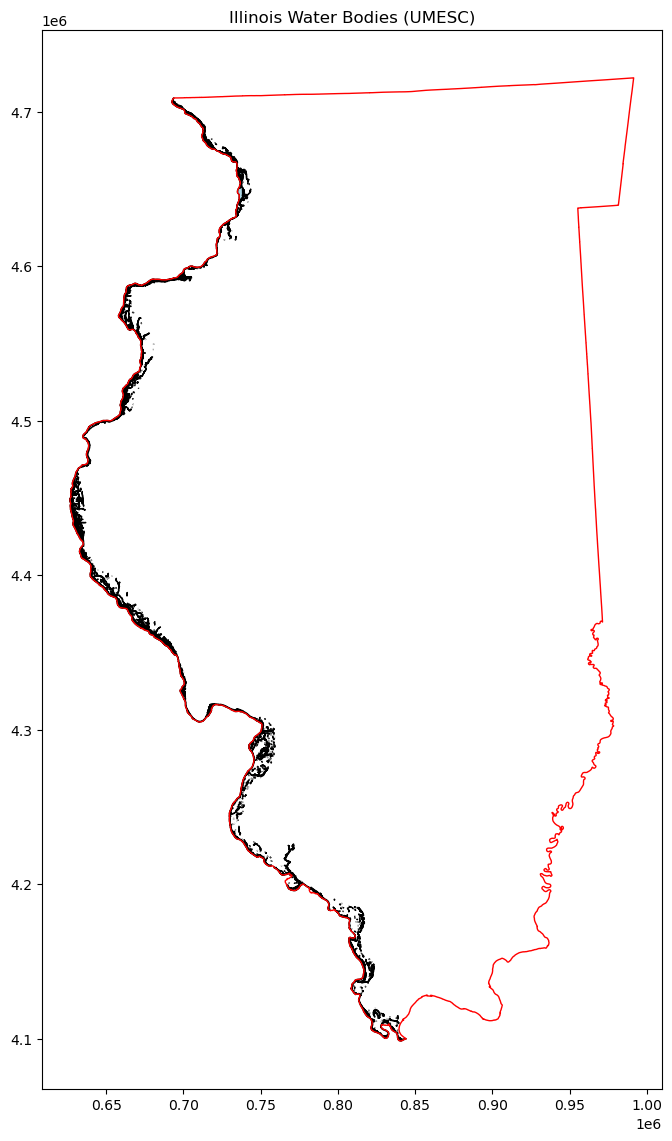

In [8]:
# Cell 3: Extract Illinois water portion
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

# Filter water polygons only
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

# Plot check
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Illinois Water Bodies (UMESC)")
plt.show()

In [9]:
print("Number of invalid geometries in water_only:", (~water_only.is_valid).sum())
print("Invalid geometries indices:", water_only[~water_only.is_valid].index)

Number of invalid geometries in water_only: 0
Invalid geometries indices: Index([], dtype='int64')


In [10]:
# Fix invalid geometries using buffer(0) - only if needed
water_only.loc[~water_only.is_valid, "geometry"] = water_only.loc[~water_only.is_valid, "geometry"].buffer(0)

# Verify
print("Invalid geometries after fix:", (~water_only.is_valid).sum())

Invalid geometries after fix: 0


In [11]:
# Ensure Illinois geometry is valid
illinois["geometry"] = illinois["geometry"].buffer(0)

# Perform clip
water_il = gpd.clip(water_only, illinois)

print("Clipped water shapes:", water_il.shape)

Clipped water shapes: (2876, 14)


In [12]:
# Combine all Illinois water polygons into a single geometry
river_il = water_il.union_all()
print(type(river_il))
print("Bounds of Illinois river section:", river_il.bounds)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
Bounds of Illinois river section: (626594.3664122473, 4098437.22724262, 844182.0029604747, 4708927.272888837)


In [13]:
# Automatic date parsing
tornadoes = pd.read_csv(tornado_csv, parse_dates=['date'])

# Filter by states, EF-scale, and date (can include stronger tornadoes on map, if necessary / min_date will likely be changed)
tornadoes = tornadoes[
    tornadoes['st'].isin(states_of_interest) &
    tornadoes['mag'].isin([0, 1, 2]) &
    (tornadoes['date'] >= min_date)
]

print("Filtered tornadoes:", tornadoes.shape)
tornadoes

Filtered tornadoes: (7841, 29)


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
6,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,...,18.80,50,1,1,1,119,117,0,0,0
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,9.60,50,1,1,1,157,0,0,0,0
11,5,1950,1,25,1950-01-25,19:30:00,3,MO,29,2,...,2.30,300,1,1,1,93,0,0,0,0
12,6,1950,1,25,1950-01-25,21:00:00,3,IL,17,3,...,0.10,100,1,1,1,91,0,0,0,0
56,48,1950,3,27,1950-03-27,16:30:00,3,IL,17,4,...,3.00,50,1,1,1,113,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71664,624857,2024,8,15,2024-08-15,22:06:00,3,IL,17,0,...,3.20,50,1,1,1,175,0,0,0,0
71687,624880,2024,8,30,2024-08-30,11:45:00,3,IL,17,0,...,0.08,20,1,1,1,157,0,0,0,0
71712,624820,2024,8,5,2024-08-05,20:57:00,3,IA,19,0,...,0.33,30,1,1,1,191,0,0,0,0
71713,624821,2024,8,5,2024-08-05,21:11:00,3,IA,19,0,...,0.98,80,1,1,1,191,0,0,0,0


In [14]:
# Remove any rows with missing or invalid coordinates
coord_cols = ['slon', 'slat', 'elon', 'elat']
tornadoes = tornadoes.dropna(subset=coord_cols)

# Remove out-of-bounds or unrealistic coordinates
tornadoes = tornadoes[
    (tornadoes['slon'].between(-180, 180)) &
    (tornadoes['elon'].between(-180, 180)) &
    (tornadoes['slat'].between(-90, 90)) &
    (tornadoes['elat'].between(-90, 90))
]
print("After coordinate cleaning:", tornadoes.shape)

After coordinate cleaning: (7841, 29)


In [15]:
# --- Fix 1: Convert positive longitudes (U.S. longitudes are negative west of Greenwich) ---
tornadoes['slon'] = tornadoes['slon'].apply(lambda x: -x if x > 0 else x)
tornadoes['elon'] = tornadoes['elon'].apply(lambda x: -x if x > 0 else x)

# --- Fix 2: Remove zero or missing coordinates (invalid positions) ---
tornadoes.loc[tornadoes['slat'] == 0, 'slat'] = np.nan
tornadoes.loc[tornadoes['elat'] == 0, 'elat'] = np.nan
tornadoes.loc[tornadoes['slon'] == 0, 'slon'] = np.nan
tornadoes.loc[tornadoes['elon'] == 0, 'elon'] = np.nan

# Drop rows with NaNs after cleaning
tornadoes = tornadoes.dropna(subset=['slon', 'slat', 'elon', 'elat']).copy()

# Check coordinate ranges again
print("Longitude range (fixed):", tornadoes[['slon', 'elon']].min().min(), "to", tornadoes[['slon', 'elon']].max().max())
print("Latitude range (fixed):", tornadoes[['slat', 'elat']].min().min(), "to", tornadoes[['slat', 'elat']].max().max())

Longitude range (fixed): -96.6 to -86.73
Latitude range (fixed): 36.0022 to 43.5808


In [16]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Create LineString or Point geometries
def make_geom(row):
    if pd.isna(row['elon']) or pd.isna(row['elat']) or \
       (row['elon'] == row['slon'] and row['elat'] == row['slat']):
        return Point(row['slon'], row['slat'])
    else:
        return LineString([(row['slon'], row['slat']), (row['elon'], row['elat'])])

tornadoes['geometry'] = tornadoes.apply(make_geom, axis=1)

# Convert to GeoDataFrame
tornado_gdf = gpd.GeoDataFrame(tornadoes, geometry='geometry', crs="EPSG:4326")

# Reproject to match water shapefile CRS
tornado_gdf = tornado_gdf.to_crs(target_crs)

print("Tornado geometries rebuilt")
print("Geometry types:", tornado_gdf.geometry.geom_type.value_counts())
print("Bounds:", tornado_gdf.total_bounds)

Tornado geometries rebuilt
Geometry types: LineString    4334
Point         1053
Name: count, dtype: int64
Bounds: [ 205367.62901075 3987738.95756939 1047129.3588023  4829035.6591338 ]


In [17]:
# Fix invalid water polygons
water_il['geometry'] = water_il['geometry'].buffer(0)

# Merge into single geometry
river_il_geom = water_il.geometry.union_all()  # or .union_all() if using new shapely

# Ensure the final geometry is valid
from shapely.validation import make_valid
river_il_geom = make_valid(river_il_geom)

In [18]:
# Buffer by 10 km
river_buffer = river_il_geom.buffer(10000)  # adjust as needed

# Check intersections with buffer
tornado_gdf['crosses_river'] = tornado_gdf.intersects(river_buffer)
crossings = tornado_gdf[tornado_gdf['crosses_river']]

print("Total weak tornadoes crossing Mississippi River or intersecting buffered zone:", crossings.shape[0])
print("Counts by EF-scale:\n", crossings['mag'].value_counts())

Total weak tornadoes crossing Mississippi River or intersecting buffered zone: 325
Counts by EF-scale:
 mag
0    124
1    122
2     79
Name: count, dtype: int64


In [19]:
#Quick sanity to make sure the river buffer is actually or approximately ~10 km (and in the right units). 

from shapely.ops import nearest_points

# Pick a point on the river geometry
river_point = river_il_geom.representative_point()

# Pick nearest point on the buffer boundary
buffer_boundary = river_buffer.boundary
nearest = nearest_points(river_point, buffer_boundary)[1]

# Compute distance in meters (UTM units)
distance_m = river_point.distance(nearest)
distance_km = distance_m / 1000
print(f"Distance from river to buffer boundary: {distance_km:.2f} km")

Distance from river to buffer boundary: 10.67 km


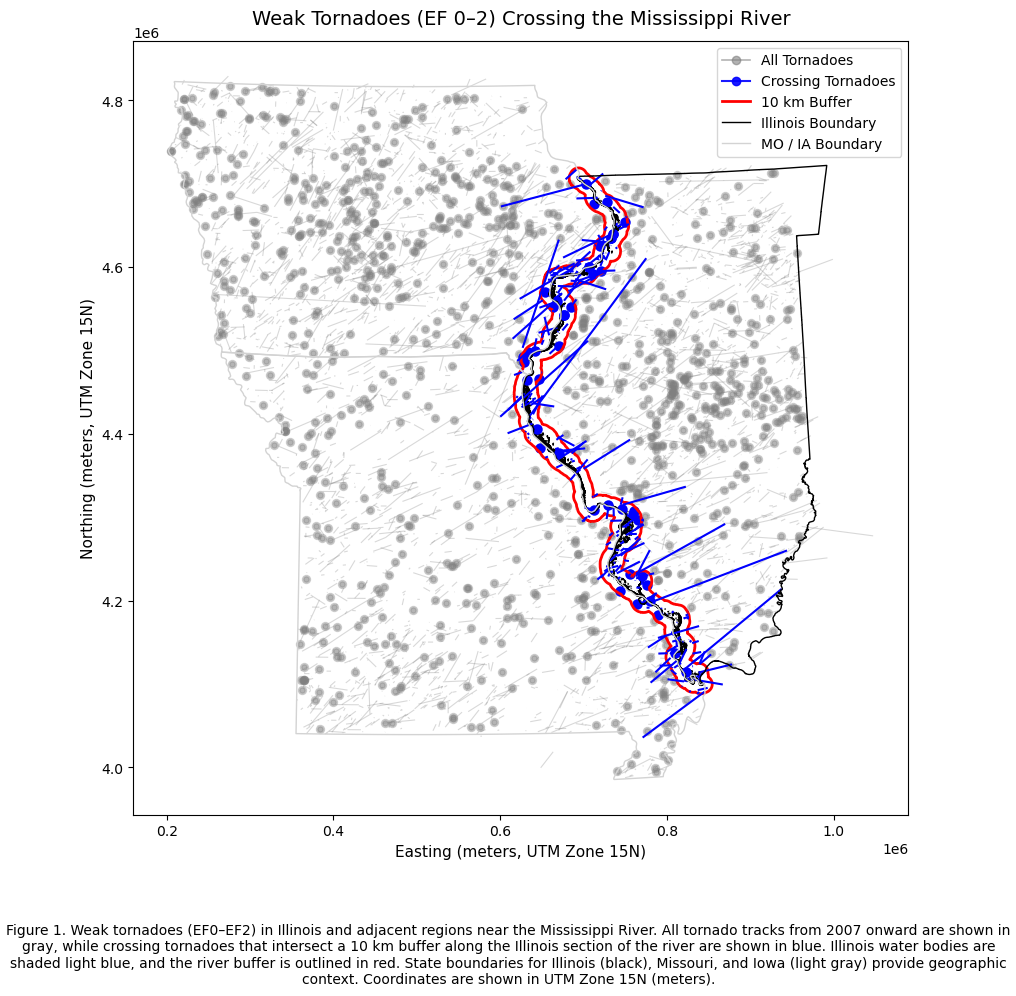

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))

# Plot Illinois water and river buffer
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')

# Plot all tornadoes (lines + points)
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
tornado_gdf[tornado_gdf.geometry.geom_type == 'Point'].plot(ax=ax, color='gray', markersize=15, alpha=0.4)

# Plot crossing tornadoes (lines + points)
crossings.plot(ax=ax, color='blue', linewidth=1.5)
crossings[crossings.geometry.geom_type == 'Point'].plot(ax=ax, color='blue', markersize=25)

# Plot Illinois, Missouri, and Iowa boundaries
illinois.boundary.plot(ax=ax, color='black', linewidth=1, label='Illinois Boundary')

states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
states = gpd.read_file(states_path).to_crs(target_crs)
states_mo_ia = states[states['name'].isin(['Missouri', 'Iowa'])]
states_mo_ia.boundary.plot(ax=ax, color='lightgray', linewidth=1, label='MO / IA Boundary')

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# --- Labels, title, and caption ---
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("Weak Tornadoes (EF 0–2) Crossing the Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)

# Figure caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF2) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 2007 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in UTM Zone 15N (meters)."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

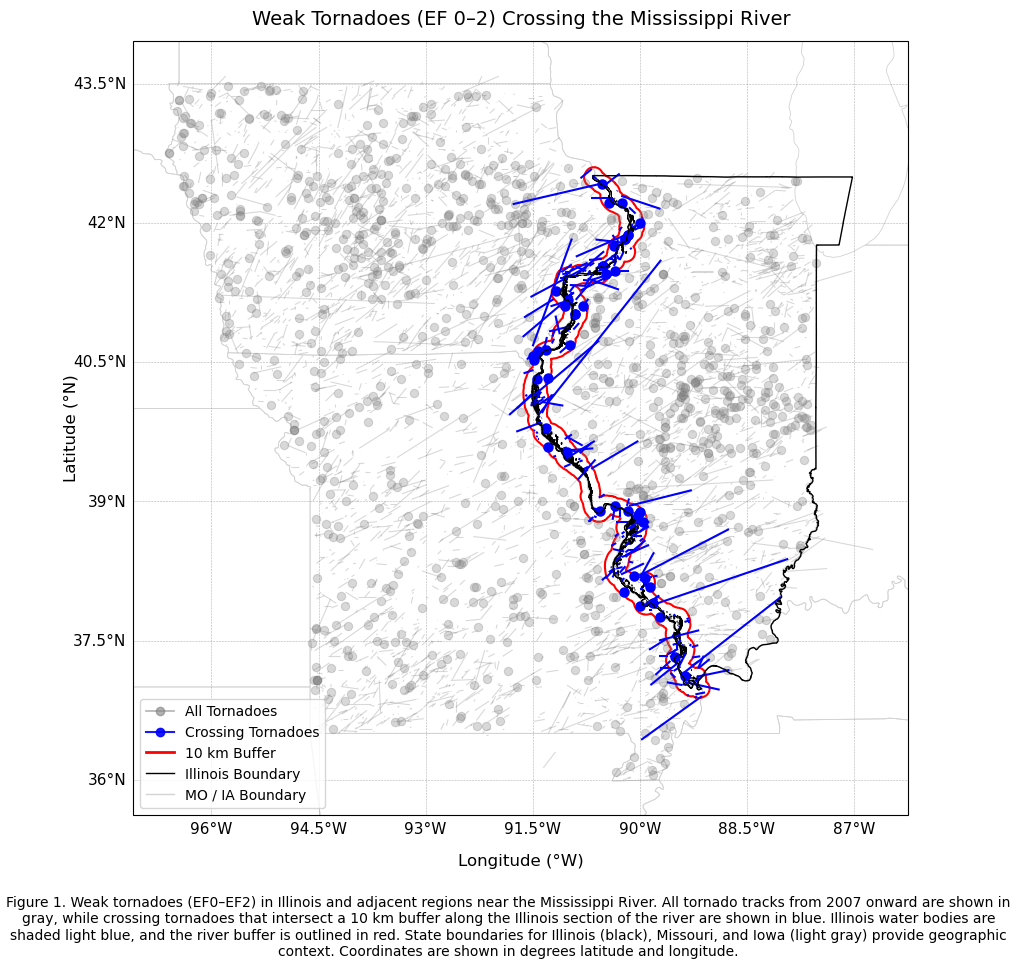

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = tornado_gdf.to_crs("EPSG:4326")
crossings_geo = crossings.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs("EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# Plot layers
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)
tornado_geo.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3, transform=ccrs.PlateCarree(), label='All Tornadoes', zorder=3)
crossings_geo.plot(ax=ax, color='blue', linewidth=1.5, transform=ccrs.PlateCarree(), label='Crossing Tornadoes', zorder=4)
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Add axis labels manually
ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# Add title and legend
ax.set_title("Weak Tornadoes (EF 0–2) Crossing the Mississippi River", fontsize=14, pad=12)
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Caption
caption = (
    "Figure 1. Weak tornadoes (EF0–EF2) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 2007 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in degrees latitude and longitude."
)
plt.figtext(0.5, 0.12, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [22]:
# -------------------------------------------------------------------
# --- Identify west-side, east-side, and crossing weak tornadoes ---
# -------------------------------------------------------------------

# 1. Start with weak tornadoes only (EF 0–2)
weak_tornadoes = tornado_gdf[tornado_gdf["mag"].isin([0, 1, 2])].copy()

# 2. Tornadoes that cross/touch the river (same as before)
crossing_tornadoes = weak_tornadoes[weak_tornadoes.intersects(river_il_geom)]

# 3. Tornadoes that are within or touch the 10 km buffer but do NOT touch/cross the river
buffer_only = weak_tornadoes[
    weak_tornadoes.intersects(river_buffer) & 
    (~weak_tornadoes.intersects(river_il_geom))
].copy()

# 4. Compute centroid of each tornado track for side determination
buffer_only["centroid"] = buffer_only.geometry.centroid

# 5. Determine whether centroids are west or east of the river
#    We'll use the river's centroid X-coordinate as an approximate divider
river_center_x = river_il_geom.centroid.x

west_side = buffer_only[buffer_only["centroid"].x < river_center_x]
east_side = buffer_only[buffer_only["centroid"].x >= river_center_x]

# 6. Print summary results
print("\n--- Weak Tornado Interaction Summary ---")
print(f"Total weak tornadoes: {len(weak_tornadoes)}")
print(f"  • West-side (within/touching 10 km buffer, not touching river): {len(west_side)}")
print(f"  • East-side (within/touching 10 km buffer, not touching river): {len(east_side)}")
print(f"  • Crossing/touching the river: {len(crossing_tornadoes)}")
print(f"  • Sum check: {len(west_side) + len(east_side) + len(crossing_tornadoes)} (should equal 325)")


--- Weak Tornado Interaction Summary ---
Total weak tornadoes: 5387
  • West-side (within/touching 10 km buffer, not touching river): 111
  • East-side (within/touching 10 km buffer, not touching river): 147
  • Crossing/touching the river: 67
  • Sum check: 325 (should equal 325)


In [23]:
# ---------- Robust classification into West Control / East Control / Test (buffer/river) ----------
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Make sure we use the variable names you have defined earlier:
# tornado_gdf  (all tornadoes, already reprojected to target_crs)
# weak_tornadoes (subset of tornado_gdf with mag in [0,1,2])
# river_il_geom  (shapely geometry of Illinois river section)
# river_buffer   (10 km buffer around river_il_geom) -- can be shapely geometry or GeoSeries

# 0) Ensure consistent CRS on weak_tornadoes
weak_tornadoes = weak_tornadoes.to_crs(target_crs)

# 1) Ensure buffer is a single (unary) shapely geometry for intersections
# If river_buffer is a GeoSeries or GeoDataFrame, get the unary_union (or .iloc[0] if single)
try:
    buffer_union = river_buffer
    # if it's a GeoSeries/GeoDataFrame convert to unary_union
    if hasattr(buffer_union, "unary_union"):
        buffer_union = buffer_union.unary_union
except NameError:
    # If river_buffer not available, create from river_il_geom
    buffer_union = river_il_geom.buffer(10000).union()

In [24]:
# 2) Test population: any weak tornado that intersects/touches the buffer OR intersects the river polygon itself
#    (this includes crossings which intersect the river geometry)
test_mask = weak_tornadoes.geometry.intersects(buffer_union) | weak_tornadoes.geometry.intersects(river_il_geom)
test_population = weak_tornadoes[test_mask].copy()

In [25]:
# 3) Outside buffer: those that do NOT intersect the buffer
outside_buffer = weak_tornadoes[~test_mask].copy()

# 4) Compute centroids (only for outside_buffer)
outside_buffer["centroid"] = outside_buffer.geometry.centroid
outside_buffer["centroid_x"] = outside_buffer["centroid"].apply(lambda p: p.x)

# 5) Robust river center x: use the centroid of the full river geometry (unary_union to be safe)
river_center_x = getattr(getattr(river_il_geom, "unary_union", river_il_geom), "centroid").x

# 6) Split outside by centroid_x relative to river_center_x
west_control = outside_buffer[outside_buffer["centroid_x"] < river_center_x].copy()
east_control = outside_buffer[outside_buffer["centroid_x"] >= river_center_x].copy()

In [26]:
# 7) Verify counts and find any unclassified (should not happen, but check)
combined_idx = test_population.index.union(west_control.index).union(east_control.index)
unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
print("Initial sizes:")
print(f"  Test population (intersect buffer/river): {len(test_population)}")
print(f"  West control (outside buffer):            {len(west_control)}")
print(f"  East control (outside buffer):            {len(east_control)}")
print(f"  Unclassified (should be 0):                {len(unclassified)}")
print(f"  Sum categories:                            {len(test_population)+len(west_control)+len(east_control)}")
print(f"  Total weak_tornadoes:                      {len(weak_tornadoes)}")

Initial sizes:
  Test population (intersect buffer/river): 325
  West control (outside buffer):            3174
  East control (outside buffer):            1888
  Unclassified (should be 0):                0
  Sum categories:                            5387
  Total weak_tornadoes:                      5387


In [27]:
# 8) If any unclassified exist (tiny rounding artifacts), assign them deterministically:
if len(unclassified) > 0:
    # compute centroid x for those too
    unclassified["centroid"] = unclassified.geometry.centroid
    unclassified["centroid_x"] = unclassified["centroid"].apply(lambda p: p.x)
    # assign by centroid_x
    assign_west = unclassified[unclassified["centroid_x"] < river_center_x].index
    assign_east = unclassified[unclassified["centroid_x"] >= river_center_x].index
    west_control = pd.concat([west_control, unclassified.loc[assign_west]])
    east_control = pd.concat([east_control, unclassified.loc[assign_east]])
    # recompute combined check
    combined_idx = test_population.index.union(west_control.index).union(east_control.index)
    unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
    print("After deterministic centroid assignment, remaining unclassified:", len(unclassified))
    # If still unclassified (very unlikely), assign by nearest distance to river centerline
    if len(unclassified) > 0:
        # build a river centerline (if you have river_centerline GeoSeries earlier use that)
        try:
            centerline = river_centerline.unary_union
        except Exception:
            # fallback: approximate centerline by taking river_il_geom.representative_point()
            centerline = river_il_geom.representative_point()
        # compute distance to centerline and assign west/east by centroid_x anyway
        for idx, row in unclassified.iterrows():
            cx = row.geometry.centroid.x
            if cx < river_center_x:
                west_control = pd.concat([west_control, row.to_frame().T])
            else:
                east_control = pd.concat([east_control, row.to_frame().T])
        
        # final check
        combined_idx = test_population.index.union(west_control.index).union(east_control.index)
        unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
        print("After fallback nearest assignment, remaining unclassified:", len(unclassified))

In [28]:
# 9) Final assert / sanity check
total_calc = len(test_population) + len(west_control) + len(east_control)
print("\nFinal totals check:")
print(f"  Sum categories = {total_calc}")
print(f"  Total weak_tornadoes = {len(weak_tornadoes)}")
assert total_calc == len(weak_tornadoes), "Final counts DO NOT sum to total weak_tornadoes!"


Final totals check:
  Sum categories = 5387
  Total weak_tornadoes = 5387


In [29]:
# 10) Create breakdown table for EF 0/1/2
def mag_counts(df):
    # Ensure mag is int-like and only 0/1/2
    s = df["mag"].astype(int).value_counts().reindex([0, 1, 2], fill_value=0)
    return s.to_dict()

summary = pd.DataFrame({
    "Category": ["West Control", "East Control", "Test (Buffer/River)"],
    "Count": [len(west_control), len(east_control), len(test_population)],
    "EF0": [mag_counts(west_control)[0], mag_counts(east_control)[0], mag_counts(test_population)[0]],
    "EF1": [mag_counts(west_control)[1], mag_counts(east_control)[1], mag_counts(test_population)[1]],
    "EF2": [mag_counts(west_control)[2], mag_counts(east_control)[2], mag_counts(test_population)[2]],
})
summary["Total EF0–EF2"] = summary[["EF0", "EF1", "EF2"]].sum(axis=1)

# Add totals row
totals = summary[["Count", "EF0", "EF1", "EF2", "Total EF0–EF2"]].sum()
totals_row = pd.DataFrame([["All Weak Tornadoes", totals["Count"], int(totals["EF0"]), int(totals["EF1"]), int(totals["EF2"]), int(totals["Total EF0–EF2"])]],
                          columns=summary.columns)
summary = pd.concat([summary, totals_row], ignore_index=True)

print("\n--- Weak Tornado Populations Summary ---")
print(summary.to_string(index=False))


--- Weak Tornado Populations Summary ---
           Category  Count  EF0  EF1  EF2  Total EF0–EF2
       West Control   3174 1506 1104  564           3174
       East Control   1888  940  682  266           1888
Test (Buffer/River)    325  124  122   79            325
 All Weak Tornadoes   5387 2570 1908  909           5387


In [30]:
# --- 1. Prepare data ---
# Add side_type column for clarity
weak_tornadoes["side_type"] = "Unclassified"
weak_tornadoes.loc[weak_tornadoes.index.isin(west_control.index), "side_type"] = "West Control"
weak_tornadoes.loc[weak_tornadoes.index.isin(east_control.index), "side_type"] = "East Control"
weak_tornadoes.loc[weak_tornadoes.index.isin(test_population.index), "side_type"] = "Test (Buffer/River)"

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = weak_tornadoes.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([buffer_union], crs=water_il.crs).to_crs("EPSG:4326")

# Split tornadoes by category for plotting
west_geo = tornado_geo[tornado_geo["side_type"] == "West Control"]
east_geo = tornado_geo[tornado_geo["side_type"] == "East Control"]
test_geo = tornado_geo[tornado_geo["side_type"] == "Test (Buffer/River)"]

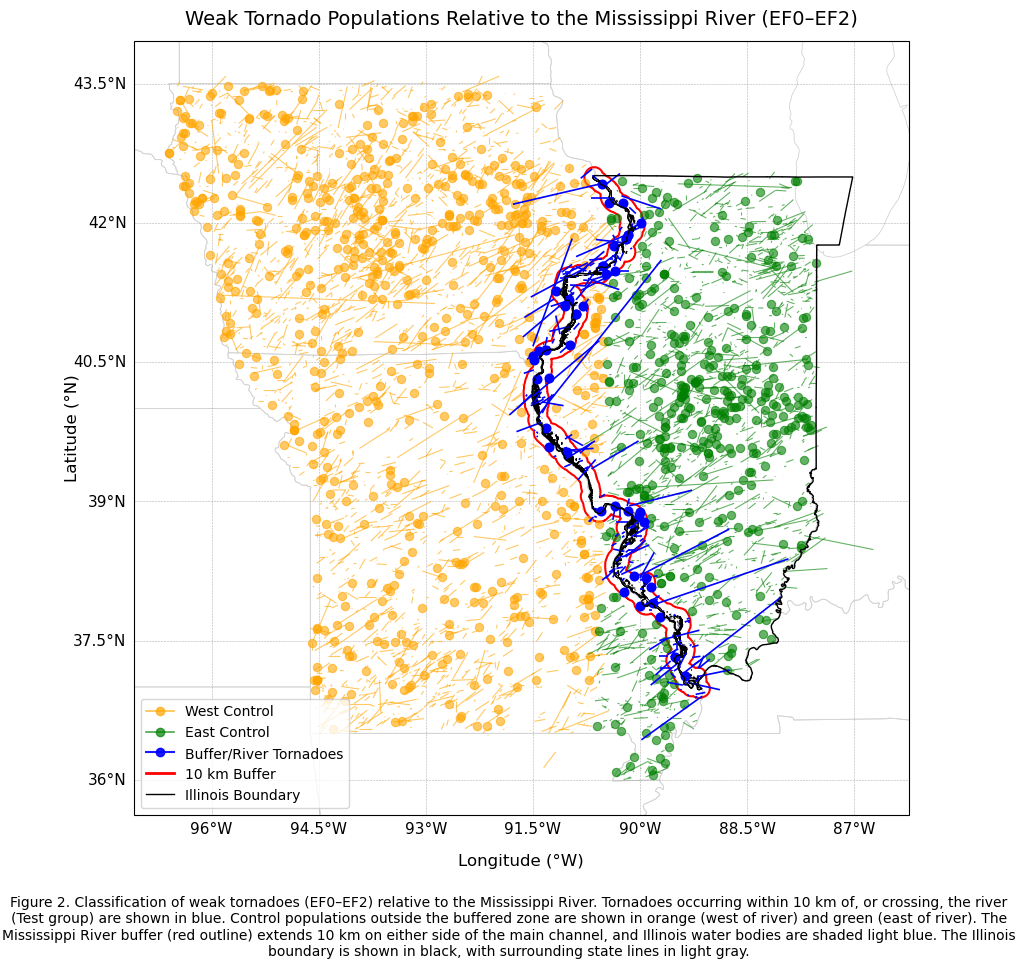

In [31]:
# --- 2. Plot setup ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Background features
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# --- 3. Plot data layers ---
# Base river and buffer
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)

# Tornado groups
west_geo.plot(ax=ax, color='orange', linewidth=0.8, alpha=0.6, transform=ccrs.PlateCarree(), label='West Control', zorder=3)
east_geo.plot(ax=ax, color='green', linewidth=0.8, alpha=0.6, transform=ccrs.PlateCarree(), label='East Control', zorder=3)
test_geo.plot(ax=ax, color='blue', linewidth=1.2, transform=ccrs.PlateCarree(), label='Buffer/River Tornadoes', zorder=4)

# State boundaries
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# --- 4. Gridlines and labels ---
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- 5. Custom legend ---
legend_elements = [
    Line2D([0], [0], color='orange', linewidth=1.2, marker='o', markersize=6, label='West Control', alpha=0.7),
    Line2D([0], [0], color='green', linewidth=1.2, marker='o', markersize=6, label='East Control', alpha=0.7),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, label='Buffer/River Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)
ax.set_title("Weak Tornado Populations Relative to the Mississippi River (EF0–EF2)", fontsize=14, pad=12)

# --- 6. Caption ---
caption = (
    "Figure 2. Classification of weak tornadoes (EF0–EF2) relative to the Mississippi River. "
    "Tornadoes occurring within 10 km of, or crossing, the river (Test group) are shown in blue. "
    "Control populations outside the buffered zone are shown in orange (west of river) and green (east of river). "
    "The Mississippi River buffer (red outline) extends 10 km on either side of the main channel, and Illinois water "
    "bodies are shaded light blue. The Illinois boundary is shown in black, with surrounding state lines in light gray."
)
plt.figtext(0.5, 0.12, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

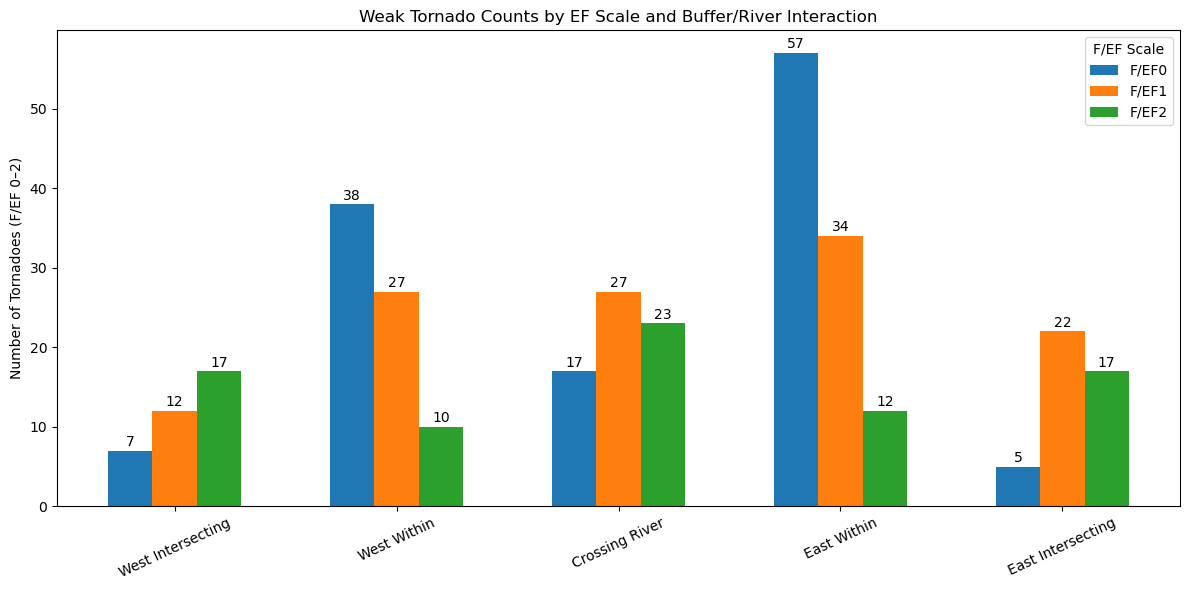

In [22]:
import matplotlib.pyplot as plt

# --- Step 1: Define helper to classify "completely within" vs "intersecting" ---
def completely_within(geom, buffer_geom):
    if geom.geom_type == "Point":
        return buffer_geom.contains(geom)
    elif geom.geom_type == "LineString":
        # Get boundary points as a list
        pts = list(geom.boundary.geoms)
        return buffer_geom.contains(pts[0]) and buffer_geom.contains(pts[1])
    return False

# --- Step 2: Separate the west and east tornadoes into intersecting vs completely within ---
west_intersecting = west_side[~west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

east_intersecting = east_side[~east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

# crossing already exists
crossing = crossing_tornadoes.copy()

# --- Step 3: Compute EF-scale counts for each bin ---
bins = {
    "West Intersecting": west_intersecting,
    "West Within": west_within,
    "Crossing River": crossing,
    "East Within": east_within,
    "East Intersecting": east_intersecting
}

ef_counts = {k: v['mag'].value_counts().reindex([0,1,2], fill_value=0) for k,v in bins.items()}

# Convert to DataFrame for plotting
ef_df = pd.DataFrame(ef_counts).T  # rows=bins, columns=EF scale
ef_df.index.name = 'Bin'
ef_df.columns = ['F/EF0', 'F/EF1', 'F/EF2']

# --- Step 4: Plot clustered bar chart ---
fig, ax = plt.subplots(figsize=(12,6))

bar_width = 0.2
x = np.arange(len(ef_df))  # 5 clusters

# Store bar containers for labeling
bars = []
for i, ef in enumerate(ef_df.columns):
    b = ax.bar(x + i*bar_width, ef_df[ef], width=bar_width, label=ef)
    bars.append(b)

# --- Add data labels on top of bars ---
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,  # center of the bar
            height + 0.2,                     # slightly above the bar
            f'{int(height)}',                 # convert to integer if counts
            ha='center', va='bottom', fontsize=10
        )

ax.set_xticks(x + bar_width)
ax.set_xticklabels(ef_df.index, rotation=25)
ax.set_ylabel("Number of Tornadoes (F/EF 0–2)")
ax.set_title("Weak Tornado Counts by EF Scale and Buffer/River Interaction")
ax.legend(title="F/EF Scale")
plt.tight_layout()
plt.show()

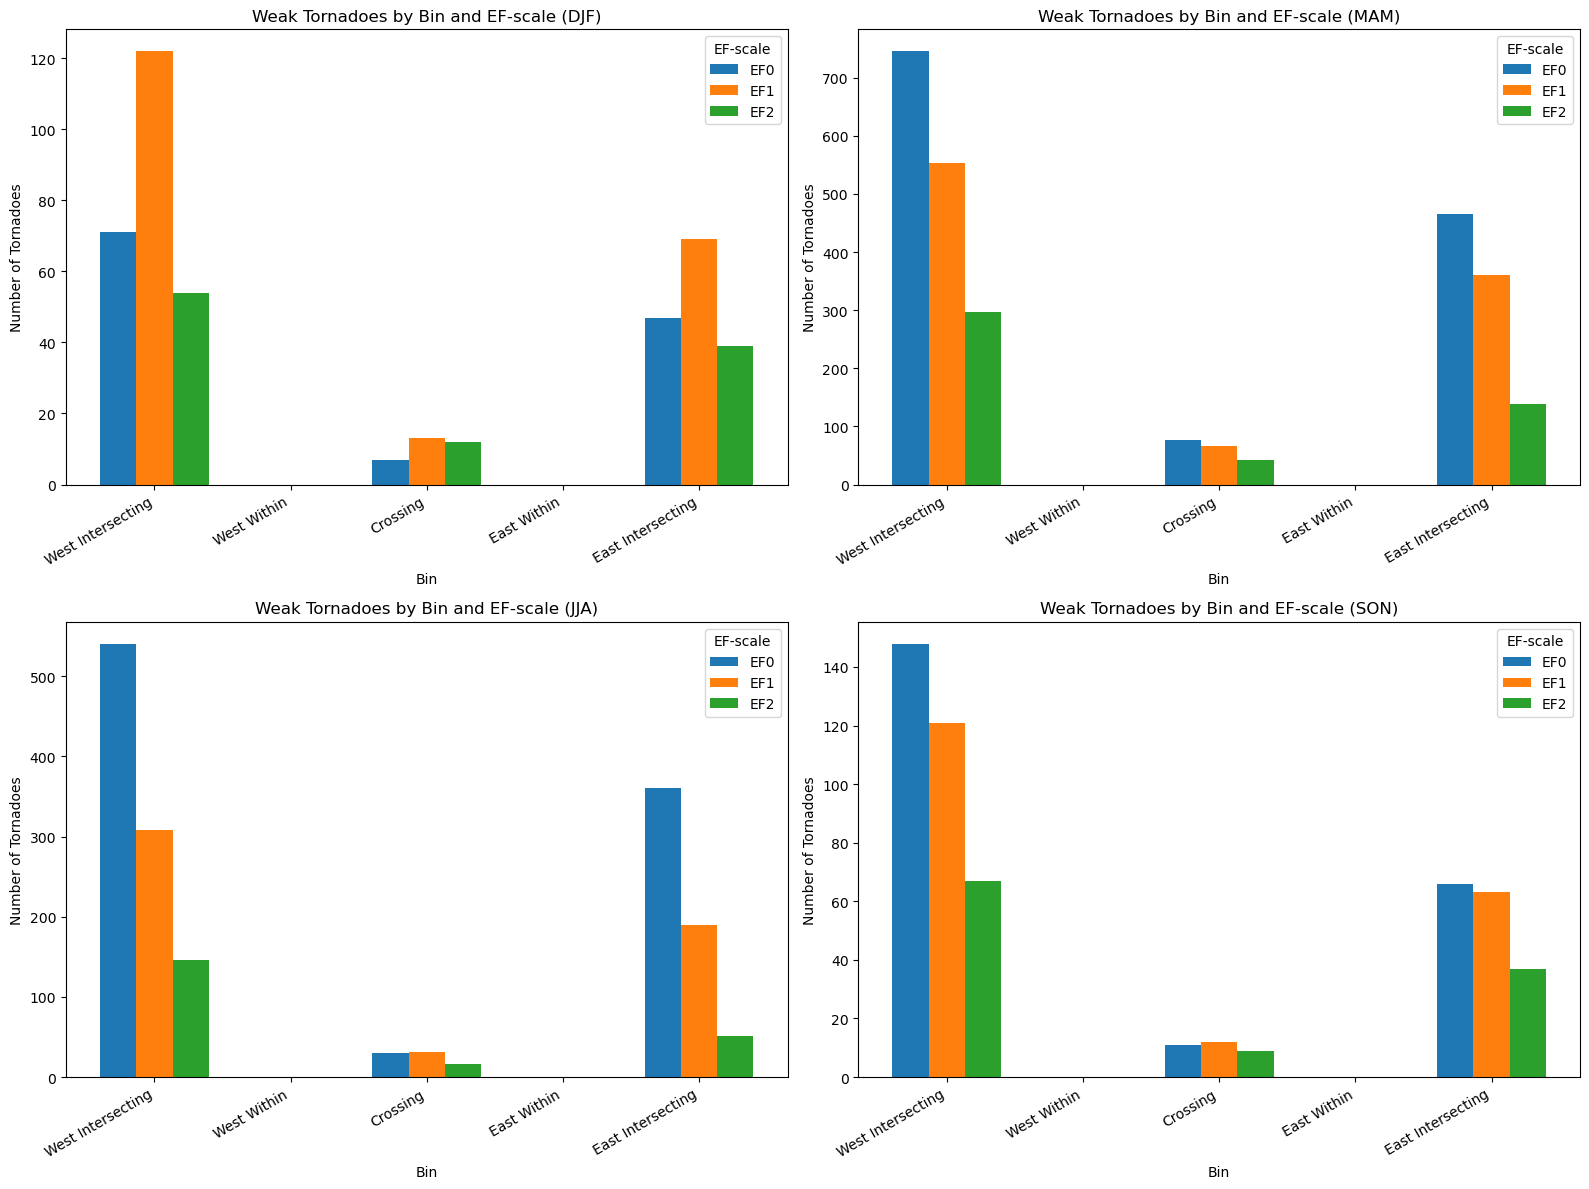

In [34]:
###############################
##Additional Work for Seasons##
###############################

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# --- Step 0: Make sure seasonal column exists ---
tornado_gdf['month'] = tornado_gdf['date'].dt.month
def get_season(month):
    if month in [12, 1, 2]: return 'DJF'
    elif month in [3, 4, 5]: return 'MAM'
    elif month in [6, 7, 8]: return 'JJA'
    else: return 'SON'
tornado_gdf['season'] = tornado_gdf['month'].apply(get_season)

# --- Step 1: Define helper functions ---
def completely_within(geom, buffer_geom):
    """Returns True if both endpoints of a LineString are within buffer_geom, or if a Point is within."""
    from shapely.geometry import Point, LineString, MultiPoint

    if geom.geom_type == 'Point':
        return buffer_geom.contains(geom)
    elif geom.geom_type == 'LineString':
        # Extract boundary points safely
        b = geom.boundary
        if isinstance(b, Point):
            pts = [b]
        elif isinstance(b, MultiPoint):
            pts = list(b.geoms)
        else:
            pts = list(b)  # fallback
        return all(buffer_geom.contains(pt) for pt in pts)
    return False

# Step 2: Pre-compute bins for all tornadoes (so seasonal plots match all-season bins)
west_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x < river_il_geom.centroid.x))]
east_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x > river_il_geom.centroid.x))]
crossing = tornado_gdf[tornado_gdf['crosses_river']==True]

# Compute intersecting vs within for west and east
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_intersecting = west_side[~west_side.index.isin(west_within.index)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_intersecting = east_side[~east_side.index.isin(east_within.index)]

# --- Step 3: Prepare seasonal counts per bin per EF-scale ---
bins_dict = {
    'West Intersecting': west_intersecting,
    'West Within': west_within,
    'Crossing': crossing,
    'East Within': east_within,
    'East Intersecting': east_intersecting
}

seasons = ['DJF', 'MAM', 'JJA', 'SON']
ef_scales = [0, 1, 2]

# --- Step 4: Plot ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    counts = []
    for bin_name, gdf_bin in bins_dict.items():
        season_bin = gdf_bin[gdf_bin['season']==season]
        ef_counts = [season_bin[season_bin['mag']==ef].shape[0] for ef in ef_scales]
        counts.append(ef_counts)
    
    counts_df = pd.DataFrame(counts, index=bins_dict.keys(), columns=[f'EF{ef}' for ef in ef_scales])
    counts_df.plot(kind='bar', stacked=False, ax=ax, width=0.8)
    
    ax.set_title(f"Weak Tornadoes by Bin and EF-scale ({season})", fontsize=12)
    ax.set_ylabel("Number of Tornadoes")
    ax.set_xlabel("Bin")
    ax.legend(title="EF-scale")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()